In [1]:
import os
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import numpy as np
import time
import psutil

In [2]:
data = pd.read_csv('/kaggle/input/mos-qoe-including-5g/output_with_5g.csv')
for i in range(len(data)):
    if data['delay_qos'][i] == -1000 \
    or data['delay_qos'][i] == 0 or data['avg_bitrate'][i] == 0:
        data = data.drop([i])
        continue
    if data['jitter'][i] == 0:
        data['jitter'][i] = 1
    if data['jitter'][i] == -1000:
        data['jitter'][i] = 1

data['mos'] = data['mos'] / 100

print (str(len(data)) + ' Data Loaded Successfully')

21870 Data Loaded Successfully


In [3]:
# Add more features: Derive new features like interactions (e.g. throughput * delay), polynomials, log transforms etc. More predictive features can reduce MSE.
data['delay_log'] = np.log(data['delay_qos']+1) 

data['bitrate_log'] = np.log(data['avg_bitrate']+1)

data['packet_loss_squared'] = data['packet_loss'] ** 2

data['throughput_jitter'] = data['throughput'] * data['jitter']

data['delay_jitter'] = data['delay_qos'] * data['jitter']

data['loss_rate'] =  data['avg_bitrate'] / (data['packet_loss'] + 1)

In [4]:
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
X = data.drop('mos', axis=1)
y = data['mos']

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Feature Selection using Random Forest
rf = RandomForestRegressor(n_estimators=500, random_state=42)
rf.fit(X_scaled, y)

# Get feature importances and select features
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Select top N features (e.g., top 10)
N = 10
selected_features = indices[:N]
X_selected = X_scaled[:, selected_features]
# If you scaled y
y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1))
X_train_sel, X_test_sel, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42)
# Then split y_scaled instead of y
# Convert data into DMatrix format (optimized for XGBoost)
dtrain = xgb.DMatrix(X_train_sel, label=y_train)
dtest = xgb.DMatrix(X_test_sel, label=y_test)

# Set parameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.01,
    'max_depth': 6,
    'colsample_bytree': 0.7,
    'subsample': 0.7,
    'n_estimators': 1000,
    'seed': 42
}

# Train the model
train_start_time = time.time() # In sec
train_start_memory = psutil.Process().memory_info().rss / 1e6  # in MB
xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    early_stopping_rounds=50,
    evals=[(dtest, 'validation')]
)
train_end_memory = psutil.Process().memory_info().rss / 1e6
train_end_time = time.time()

# Make predictions
predict_start_time = time.time()
predict_start_memory = psutil.Process().memory_info().rss / 1e6  # Memory in MB
y_pred_xgb = xgb_model.predict(dtest)
predict_end_memory = psutil.Process().memory_info().rss / 1e6
predict_end_time = time.time()

# Compute metrics
r2_xgb = r2_score(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

print("XGBoost Model:")
print(f"R²: {r2_xgb:.4f}")
print(f"MSE: {mse_xgb:.8f}")
print(f"RMSE: {rmse_xgb:.8f}")
print(f"MAE: {mae_xgb:.8f}")


[0]	validation-rmse:0.00963
[1]	validation-rmse:0.00955
[2]	validation-rmse:0.00948
[3]	validation-rmse:0.00941
[4]	validation-rmse:0.00934
[5]	validation-rmse:0.00927
[6]	validation-rmse:0.00921
[7]	validation-rmse:0.00914
[8]	validation-rmse:0.00907
[9]	validation-rmse:0.00901
[10]	validation-rmse:0.00894
[11]	validation-rmse:0.00888
[12]	validation-rmse:0.00881
[13]	validation-rmse:0.00875
[14]	validation-rmse:0.00869
[15]	validation-rmse:0.00863
[16]	validation-rmse:0.00857
[17]	validation-rmse:0.00851
[18]	validation-rmse:0.00845
[19]	validation-rmse:0.00839
[20]	validation-rmse:0.00833
[21]	validation-rmse:0.00827
[22]	validation-rmse:0.00822
[23]	validation-rmse:0.00818
[24]	validation-rmse:0.00813
[25]	validation-rmse:0.00807
[26]	validation-rmse:0.00802
[27]	validation-rmse:0.00797
[28]	validation-rmse:0.00792
[29]	validation-rmse:0.00787


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:04:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[30]	validation-rmse:0.00782
[31]	validation-rmse:0.00777
[32]	validation-rmse:0.00772
[33]	validation-rmse:0.00767
[34]	validation-rmse:0.00762
[35]	validation-rmse:0.00758
[36]	validation-rmse:0.00753
[37]	validation-rmse:0.00748
[38]	validation-rmse:0.00744
[39]	validation-rmse:0.00739
[40]	validation-rmse:0.00735
[41]	validation-rmse:0.00730
[42]	validation-rmse:0.00726
[43]	validation-rmse:0.00722
[44]	validation-rmse:0.00718
[45]	validation-rmse:0.00714
[46]	validation-rmse:0.00710
[47]	validation-rmse:0.00706
[48]	validation-rmse:0.00702
[49]	validation-rmse:0.00698
[50]	validation-rmse:0.00695
[51]	validation-rmse:0.00691
[52]	validation-rmse:0.00687
[53]	validation-rmse:0.00683
[54]	validation-rmse:0.00680
[55]	validation-rmse:0.00676
[56]	validation-rmse:0.00672
[57]	validation-rmse:0.00669
[58]	validation-rmse:0.00666
[59]	validation-rmse:0.00662
[60]	validation-rmse:0.00659
[61]	validation-rmse:0.00656
[62]	validation-rmse:0.00652
[63]	validation-rmse:0.00649
[64]	validatio

## Benchmark

In [5]:
benchmark = {
    "train_time (s)": round(train_end_time - train_start_time,2),
    "train_memory (MB)": round(train_end_memory - train_start_memory,2),
    "prediction_latency (s)": round(predict_end_time - predict_start_time,2),
    "prediction_memory (MB)": round(predict_end_memory - predict_start_memory,2),
    "throughput (samples/second)": round(len(X_train_sel) / (predict_end_time - predict_start_time), 2)
}

benchmark

{'train_time (s)': 4.34,
 'train_memory (MB)': 18.63,
 'prediction_latency (s)': 0.04,
 'prediction_memory (MB)': 0.0,
 'throughput (samples/second)': 480507.22}

## Scalability

In [6]:
def resource_scalability(model, X_test, sizes, y_test):
    results = []
    for size in sizes:
        # Extract the subset of features and labels
        subset = X_test[:size]
        label_subset = y_test[:size]  # Match the size of labels with the subset
        
        # Create DMatrix with subset
        dtest = xgb.DMatrix(subset, label=label_subset)
        
        # Start monitoring
        start_time = time.time()
        
        # Predict
        model.predict(dtest)
        
        # Stop monitoring
        end_time = time.time()
        
        # Record results
        results.append({
            "Dataset Size": size,
            "Prediction Delay (s)": round(end_time - start_time, 3),
        })
    
    return results

# Example usage
sizes = [500, 1000, 2000, 3000, len(X_test_sel)]
resource_results = resource_scalability(xgb_model, X_test_sel, sizes, y_test)
scalability_df = pd.DataFrame(resource_results)

# Convert to DataFrame
resource_df = pd.DataFrame(resource_results)
print(resource_df)

   Dataset Size  Prediction Delay (s)
0           500                 0.004
1          1000                 0.009
2          2000                 0.015
3          3000                 0.023
4          4374                 0.034


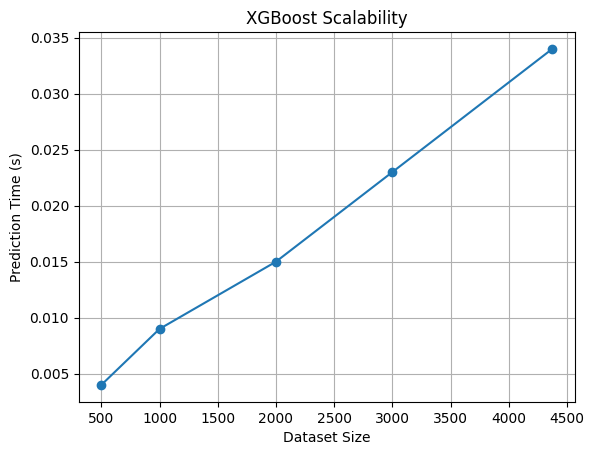

In [7]:
plt.plot(scalability_df["Dataset Size"], scalability_df["Prediction Delay (s)"], marker='o')
plt.title("XGBoost Scalability")
plt.xlabel("Dataset Size")
plt.ylabel("Prediction Time (s)")
plt.grid(True)
plt.show()